<a href="https://www.kaggle.com/code/miltiadesgeneral/tensorflow-melspectro-efficientnetb0?scriptVersionId=128697491" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Import Libraries 

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

import math, random
import os
import csv
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import librosa
import torch
import torchaudio
from torchvision.models import resnet34
from torchaudio import transforms
from IPython.display import Audio

from sklearn.preprocessing import LabelEncoder

## Configuration

In [2]:
class Config:
    device = "tpu"
    
    base_path = "/kaggle/input/birdclef-2023"
    train_metadata = "/train_metadata.csv"
    train_audio = "/train_audio"
    test_audio = "/test_soundscapes"
    taxonomies = "/eBird_Taxonomy_v2021.csv"
    sample_submission = "/sample_submission.csv"
    
    audio_length = 5 # seconds
    sample_rate = 32000
    image_size = (512, 512)
    
    # Mel Spectrogram
    mels = 30
    fmin = 0
    fmax = 8000
    n_fft= 700
    hop_length = 548
    
    # Masking
    max_mask_pct = 0.1
    n_freq_masks = 1
    n_time_masks = 1
    
    batch_size = 16
    
    epochs = 4

In [3]:
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
# tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
# tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))

# strategy = tf.distribute.TPUStrategy(resolver)

## Import the Metadata Dataframe

In [4]:
# Define the metadata path
metadata_path = Path(Config.base_path + Config.train_metadata)

df = pd.read_csv(metadata_path)
df["filename"] = df["filename"].apply(lambda x: Config.base_path + Config.train_audio + "/" + x)
# df['filename'] = df['filename'].str.replace('.ogg', '.wav')
df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,abethr1,[],['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/128013,/kaggle/input/birdclef-2023/train_audio/abethr...
1,abethr1,[],['call'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363501,/kaggle/input/birdclef-2023/train_audio/abethr...
2,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363502,/kaggle/input/birdclef-2023/train_audio/abethr...
3,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/363503,/kaggle/input/birdclef-2023/train_audio/abethr...
4,abethr1,[],"['call', 'song']",-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://www.xeno-canto.org/363504,/kaggle/input/birdclef-2023/train_audio/abethr...


In [5]:
from sklearn.utils import resample
target_size = math.ceil(df["primary_label"].value_counts().mean())

df_balanced = pd.DataFrame()


for class_label in df["primary_label"].unique():
    resampled_df = resample(df[df["primary_label"] == class_label], n_samples=target_size)
    df_balanced = pd.concat([
        df_balanced, 
        resampled_df
    ], ignore_index=True)
    
    
df = df_balanced

In [6]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)

# cats = df["primary_label"]
encoded_classes = enc.fit_transform(df[['primary_label']].values.reshape(-1, 1))
class_names = enc.get_feature_names_out(['class'])
class_df = pd.DataFrame(encoded_classes, columns=class_names)
class_df[class_names] = class_df[class_names].astype(int)

In [7]:
df = pd.concat([
    df,
    class_df
], axis=1)
df

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,...,class_yebsto1,class_yeccan1,class_yefcan,class_yelbis1,class_yenspu1,class_yertin1,class_yesbar1,class_yespet1,class_yetgre1,class_yewgre1
0,abethr1,['rbsrob1'],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,...,0,0,0,0,0,0,0,0,0,0
1,abethr1,[],"['adult', 'sex uncertain', 'song']",-2.9858,37.5975,Turdus tephronotus,African Bare-eyed Thrush,isaac kilusu,Creative Commons Attribution-NonCommercial-Sha...,4.0,...,0,0,0,0,0,0,0,0,0,0
2,abethr1,[],[''],-3.1552,40.1326,Turdus tephronotus,African Bare-eyed Thrush,Lars Lachmann,Creative Commons Attribution-NonCommercial-Sha...,3.0,...,0,0,0,0,0,0,0,0,0,0
3,abethr1,[],[''],-3.1552,40.1326,Turdus tephronotus,African Bare-eyed Thrush,Lars Lachmann,Creative Commons Attribution-NonCommercial-Sha...,3.0,...,0,0,0,0,0,0,0,0,0,0
4,abethr1,[],"['adult', 'sex uncertain', 'song']",-2.9858,37.5975,Turdus tephronotus,African Bare-eyed Thrush,isaac kilusu,Creative Commons Attribution-NonCommercial-Sha...,4.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17155,yewgre1,[],['call'],-1.3589,29.6187,Eurillas latirostris,Yellow-whiskered Greenbul,Martin St-Michel,Creative Commons Attribution-NonCommercial-Sha...,3.0,...,0,0,0,0,0,0,0,0,0,1
17156,yewgre1,[],['call'],-0.6567,30.9237,Eurillas latirostris,Yellow-whiskered Greenbul,Hans Groot,Creative Commons Attribution-NonCommercial-Sha...,4.0,...,0,0,0,0,0,0,0,0,0,1
17157,yewgre1,[],"['adult', 'sex uncertain', 'song']",-1.2474,36.8231,Eurillas latirostris,Yellow-whiskered Greenbul,isaac kilusu,Creative Commons Attribution-NonCommercial-Sha...,3.0,...,0,0,0,0,0,0,0,0,0,1
17158,yewgre1,[],['call'],-0.9890,29.6160,Eurillas latirostris,Yellow-whiskered Greenbul,Martin St-Michel,Creative Commons Attribution-NonCommercial-Sha...,4.0,...,0,0,0,0,0,0,0,0,0,1


Text(0.5, 1.0, 'Bird Class Distribution')

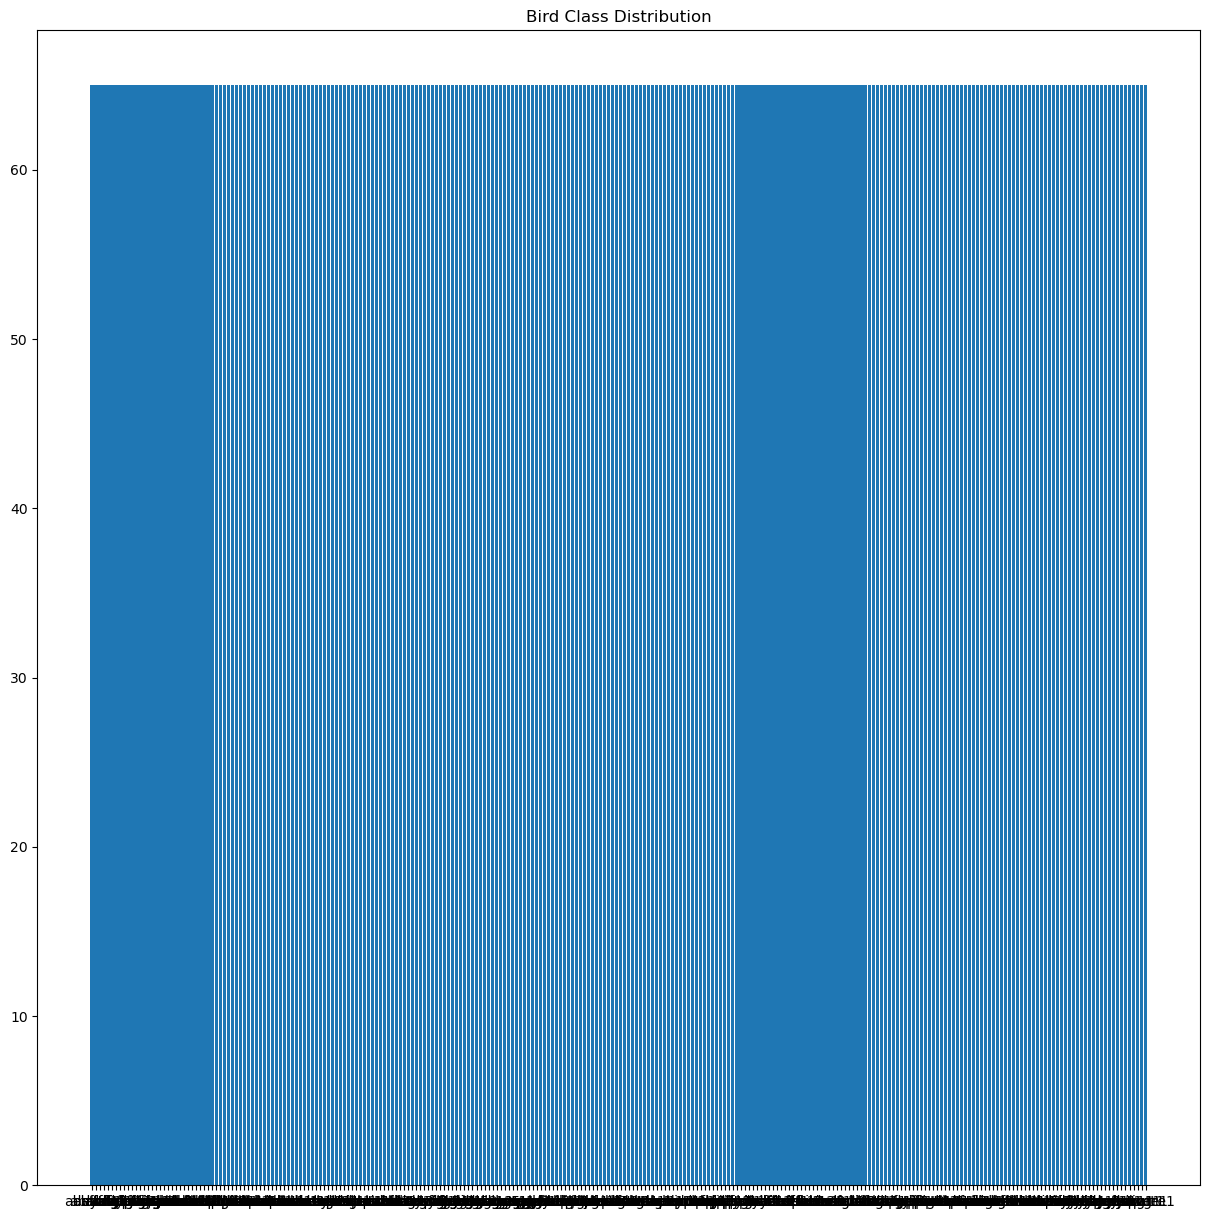

In [8]:
figure = plt.figure(figsize=[15, 15])
plt.bar(df["primary_label"].unique(), df["primary_label"].value_counts())
plt.title("Bird Class Distribution")

In [9]:
labels_path = hub.resolve('https://kaggle.com/models/google/bird-vocalization-classifier/frameworks/tensorFlow2/variations/bird-vocalization-classifier/versions/1') + "/assets/label.csv"

In [10]:
# Credit @PHIL CULLITON https://www.kaggle.com/code/philculliton/inferring-birds-with-kaggle-models

# Find the name of the class with the top score when mean-aggregated across frames.
def class_names_from_csv(class_map_csv_text):
    """Returns list of class names corresponding to score vector."""
    with open(labels_path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        class_names = [mid for mid, desc in csv_reader]
        return class_names[1:]

## note that the bird classifier classifies a much larger set of birds than the
## competition, so we need to load the model's set of class names or else our 
## indices will be off.
classes = class_names_from_csv(labels_path)

In [11]:
competition_classes = sorted(df.primary_label.unique())
new_class = len(classes)
competition_class_map = {}
unseen_classes = []
for c in competition_classes:
    try:
        i = classes.index(c)
        competition_class_map[c] = i
    except:
        competition_class_map[c] = new_class
        unseen_classes.append(c)
        new_class += 1        

        
## this is the count of classes not supported by our pretrained model
## you could choose to simply not predict these, set a default as above,
## or create your own model using the pretrained model as a base.
unseen_classes

['fotdro5', 'quailf1', 'sacibi2']

## Define the data preprocessing functions
Audio must be:
- Loaded as a tensor
- Rechanneled if needed
- Resampled
- Set to proper length (Padding/truncation)
- Time Shifted
- Turned into a Mel Spectrogram
- Spectro Time Masking
- Spectro Frequency Masking

In [36]:
class AudioUtils():
    """
    Loading and preprocessing
    """
    @staticmethod
    def openFile(filepath, label):
        """
        Reads a filepath and returns a lazy-loaded IOtensor.
        """
        audio_tensor = tf.io.read_file(filepath)
        audio_tensor = tfio.audio.decode_vorbis(audio_tensor)
        audio_tensor = tf.cast(audio_tensor, dtype=tf.float32) / 32768.0 
        audio_tensor = tf.squeeze(audio_tensor, axis=[-1])
        return audio_tensor, label
    
    @staticmethod
    def playAudio(t, label):
        """
        Use Ipython to preview the audio sample
        """
        length = int(tf.shape(t)[0].numpy())
        
#         audio_tensor = tf.squeeze(t, axis=[-1])
        audio_tensor = t
        return Audio(audio_tensor.numpy(), rate=32000)
    
    @staticmethod
    def visualizeAudio(t, label):
        """
        Visualize the audio in waveform
        """
        # Convert it to a float32 tensor
        visual_tensor = tf.squeeze(t, axis=[-1])
        visual_tensor = tf.cast(t, tf.float32) / 32768.0
        
        # Plot
        plt.figure()
        plt.plot(visual_tensor.numpy())
    
    @staticmethod
    def resizeTensor(t, label, sr=32000, desired_length=Config.audio_length, random_start=False):
        """
        the length of the audio clip to the desired length
        """
        tensor_size = int(tf.shape(t)[0].numpy())
        if tensor_size > (desired_length * sr):
            resized_audio_tensor = tf.image.random_crop(t, size=[sr * Config.audio_length, ]) # Random crop to 5 seconds
            
        else:
            # Find the missing length to fill the tensor
            rem = (desired_length * sr) - tensor_size
            # Create a start padding and end padding to add to the tensor
            front_pad, back_pad = tf.zeros(math.floor(rem/2)), tf.zeros(math.ceil(rem/2))
            # Resize 
            resized_audio_tensor = tf.concat([front_pad, t, back_pad], 0)
        
        return resized_audio_tensor, label
    
    @staticmethod
    def resample(t, label, input_rate=32000, desired_rate=Config.sample_rate):
        if (input_rate == desired_rate):
            return t, label
        resampled_tensor = tfio.audio.resample(t, rate_in=input_rate, rate_out=desired_rate)
        resampled_tensor = tf.squeeze(resampled_tensor, axis=[-1])
        return resampled_tensor, label
    
    """
    Data Augmentations
    """
    @staticmethod
    def shiftTime(t, label, shift_limit=0.4):
        """
        Roll the time randomly
        """
        sig_len = int(tf.shape(t)[0].numpy())
        shift_amt = int(random.random() * shift_limit * sig_len)
        t = tf.roll(t, shift_amt, 0)
        return t, label
    
    @staticmethod
    def createMelSpectrogram(t, label, sample_rate=Config.sample_rate, nfft=Config.n_fft, mels=Config.mels, fmin=Config.fmin, fmax=Config.fmax, top_db=80):
        """
        Create a mel spectrogram by scaling the frequency and the amplitude 
        """
        spectrogram = tfio.audio.spectrogram(
            t, nfft=nfft, window=nfft, stride=300)
        # Melscale the frequency
        mel_spectrogram = tfio.audio.melscale(
            spectrogram, sample_rate, 40, fmin, fmax
        )
        # Mel scale the amplitude
        mel_spectrogram = tfio.audio.dbscale(
            mel_spectrogram, top_db=top_db
        )
#         mel_spectrogram = tf.reshape(mel_spectrogram, [534, 40, 1])
#         resized_mel_spectrogram = tf.image.resize(mel_spectrogram, [*Config.image_size])
#         resized_mel_spectrogram = tf.repeat(resized_mel_spectrogram, 3, axis=-1)
        return mel_spectrogram, label
        
        
    @staticmethod
    def spectroMasking(spectro, label, max_mask_pct=Config.max_mask_pct, n_freq_masks=Config.n_freq_masks, n_time_masks=Config.n_time_masks):
        """
        Apply masking methods to the time and frequency axes of the mel spectrogram
        """
        n_mels, n_steps = 40, 300
        aug_spec = spectro
        
        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = tfio.audio.freq_mask(aug_spec, param=2)
            
        time_mask_param = int(max_mask_pct * n_steps)
        for _ in range(n_time_masks):
            aug_spec = tfio.audio.time_mask(aug_spec, param=2)
        
        return aug_spec, label
    
    @staticmethod
    def resizeFinalTensor(spectro, label):
        resized_mel_spectrogram = tf.reshape(spectro, [534, 40, 1])
        resized_mel_spectrogram = tf.image.resize(resized_mel_spectrogram, [*Config.image_size])
        resized_mel_spectrogram = tf.repeat(resized_mel_spectrogram, 3, axis=-1)
        return resized_mel_spectrogram, label
    
    @staticmethod
    def normalize(spectro, label):
        """
        Normalize the values to between 0 and 1
        """
        max_value = tf.reduce_max(spectro)
        normalized_tensor = spectro / max_value
        return normalized_tensor, label
    
    
    @staticmethod
    def visualizeSpectro(spectro, label):
        img = spectro.numpy()
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        plt.figure()
#         plt.imshow(img.transpose([1, 0]), cmap='gray')
        plt.imshow(img)



In [13]:
# rand = random.randrange(0, len(df) - 1)
# example = df.iloc[rand, -265:]
# class_name = df.loc[rand, "primary_label"]
# filepath = example["filename"]
# example_label = list(example.iloc[-264:].values)

# audio, label = AudioUtils.openFile(filepath, example_label)
# audio, label = AudioUtils.resizeTensor(audio, label)

# display(class_name)
# AudioUtils.playAudio(audio, label)

In [14]:
AUTO = tf.data.experimental.AUTOTUNE
filenames, labels = df.loc[:, "filename"].values, df.loc[:, class_names].values
file_dataset = tf.data.Dataset.from_tensor_slices(filenames.astype(bytes))
labels_dataset = tf.data.Dataset.from_tensor_slices(labels)
labels_dataset = labels_dataset.map(lambda x: tf.cast(x, dtype=tf.int32), num_parallel_calls=AUTO)
dataset = tf.data.Dataset.zip((file_dataset, labels_dataset))
dataset = dataset.shuffle(2048)
dataset = dataset.map(lambda x, y: (AudioUtils.openFile(x, y)), num_parallel_calls=AUTO)
dataset = dataset.map(lambda x, y: (tf.py_function(func=AudioUtils.resizeTensor, 
                                                   inp=[x, y], 
                                                   Tout=[tf.float32,tf.int32])))
dataset = dataset.map(lambda x, y: (AudioUtils.resample(x, y)), num_parallel_calls=AUTO)
dataset = dataset.map(lambda x, y: (tf.py_function(func=AudioUtils.shiftTime, 
                                                   inp=[x, y], 
                                                   Tout=[tf.float32,tf.int32])))

dataset = dataset.map(lambda x, y: (tf.py_function(func=AudioUtils.createMelSpectrogram, 
                                                   inp=[x, y], 
                                                   Tout=[tf.float32,tf.int32])))
dataset = dataset.map(lambda x, y: (tf.py_function(func=AudioUtils.spectroMasking, 
                                                   inp=[x, y], 
                                                   Tout=[tf.float32,tf.int32])))
dataset = dataset.map(lambda x, y: (AudioUtils.resizeFinalTensor(x, y)))
dataset = dataset.map(lambda x, y: (AudioUtils.normalize(x, y)))
dataset = dataset.batch(Config.batch_size)

In [15]:
def _fixup_shape(images, labels):
    images.set_shape([None, None, None, 3])
    labels.set_shape([None, len(class_names)])
    return images, labels

dataset = dataset.map(_fixup_shape)
dataset = dataset.prefetch(buffer_size=AUTO)

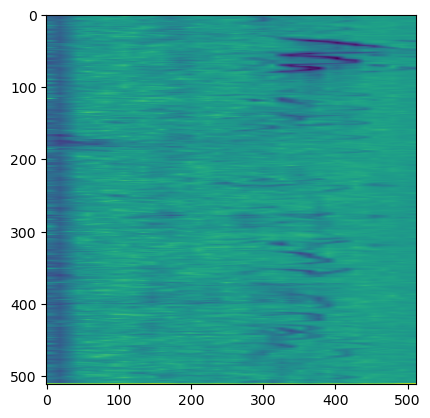

In [16]:
for x, y in dataset.take(1):
    example, ex_label = x[0], y[0]
    AudioUtils.visualizeSpectro(example, ex_label)
    break
    
# AudioUtils.visualizeSpectro(example, ex_label)

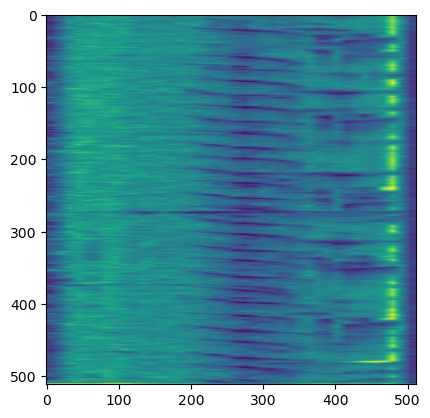

In [45]:
sample_file, sample_label = filenames[200], labels[200]
util = AudioUtils()

audio, label = util.openFile(sample_file, sample_label)
resized_audio, label = util.resizeTensor(audio, label)
resampled_audio, label = util.resample(resized_audio, label)
mel_spectrogram, label = util.createMelSpectrogram(resampled_audio, label)
resized_mel, label = util.resizeFinalTensor(mel_spectrogram, label)
normalized_mel, label = util.normalize(resized_mel, label)
util.visualizeSpectro(normalized_mel, label)

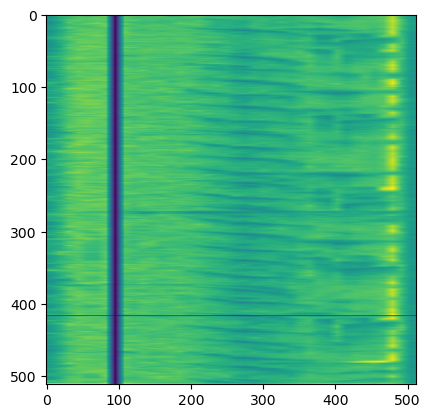

In [46]:
masked_mel_spectrogram, label = util.spectroMasking(mel_spectrogram, label)
resized_mel, label = util.resizeFinalTensor(masked_mel_spectrogram, label)
normalized_mel, label = util.normalize(resized_mel, label)
util.visualizeSpectro(normalized_mel, label)

### Train, Test, Val Split

In [17]:
# Credit @Angel Igareta https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=False, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset, len(dataset))

In [19]:
for x,y in train_ds:
    print(tf.shape(x), tf.shape(y))
    break

tf.Tensor([ 16 256 256   3], shape=(4,), dtype=int32) tf.Tensor([ 16 264], shape=(2,), dtype=int32)


## Load and Train the EfficientNetB0 Model

In [20]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
NUM_CLASSES = len(class_names)
with strategy.scope():
    inputs = layers.Input(shape=(*Config.image_size, 3))
    outputs = tf.keras.applications.efficientnet.EfficientNetB0(include_top=True, 
                                                                weights=None, 
                                                                classes=NUM_CLASSES, 
                                                                input_shape=(*Config.image_size, 3))(inputs)
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy']
    )
    
# Define the ModelCheckpoint callback with a filepath that includes the epoch number
checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath='/kaggle/working/256-px_wmasking_run_1_weights.h5', 
                                                  monitor='val_loss', 
                                                  save_weights_only=True,
                                                  mode='auto')
    
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 264)              4387755   
                                                                 
Total params: 4,387,755
Trainable params: 4,345,732
Non-trainable params: 42,023
_________________________________________________________________


In [21]:
# model.load_weights("/kaggle/input/256-px-run-2-weights/256-px_run_2_weights.h5")

In [22]:
import time
epochs = 14
start = time.time()
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=1, callbacks=[checkpoints])
end  = time.time()

Epoch 1/14


2023-05-06 19:58:49.149205: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


858/858 [==============================] - 2291s 3s/step - loss: 2.8936 - accuracy: 0.3659 - val_loss: 6.1117 - val_accuracy: 0.2535
Epoch 2/14
858/858 [==============================] - 2132s 2s/step - loss: 2.4164 - accuracy: 0.4383 - val_loss: 7.0922 - val_accuracy: 0.2950
Epoch 3/14
858/858 [==============================] - 2117s 2s/step - loss: 2.2055 - accuracy: 0.4848 - val_loss: 6.9063 - val_accuracy: 0.3370
Epoch 4/14
858/858 [==============================] - 2128s 2s/step - loss: 2.0477 - accuracy: 0.5168 - val_loss: 7.3694 - val_accuracy: 0.3394
Epoch 5/14
858/858 [==============================] - 2127s 2s/step - loss: 1.8740 - accuracy: 0.5506 - val_loss: 7.2651 - val_accuracy: 0.3867
Epoch 6/14
858/858 [==============================] - 2111s 2s/step - loss: 1.7576 - accuracy: 0.5833 - val_loss: 7.3233 - val_accuracy: 0.3978
Epoch 7/14
858/858 [==============================] - 2103s 2s/step - loss: 1.6341 - accuracy: 0.6101 - val_loss: 7.6035 - val_accuracy: 0.4165
Epo

In [23]:
model.save_weights("/kaggle/working/256-px_run_3_weights.h5")

In [24]:
duration = (end-start) / 60
duration

496.9732526183128

In [25]:
# Define a callback to update the checkpoint filepath with the epoch number
class UpdateCheckpointPathCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Update the checkpoint filepath with the epoch number
        new_filepath = f'/kaggle/working/epoch_{epoch+1:02d}_saved_weights.h5'
        self.model.checkpoints.filepath = new_filepath

# Instantiate the callback
update_checkpoint_path_callback = UpdateCheckpointPathCallback()

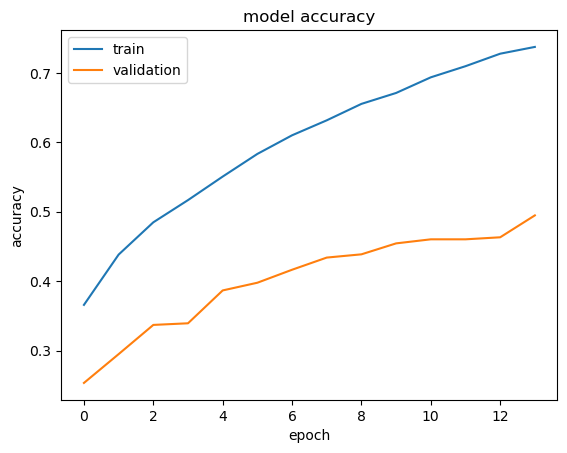

In [26]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

# Custom Train Loader
_______________________________________________________________

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

model = tf.keras.applications.efficientnet.EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3),
    drop_connect_rate=0.4,
)

input_shape = (224, 224, 3)
# Define the pre-processing layers for the input spectrogram
preprocessing_layers = [
    preprocessing.Normalization(),
]

# Define the spectrogram classification model
model = tf.keras.Sequential([
    tf.keras.Input(shape=input_shape),
    *preprocessing_layers,
    model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
loss_object = tf.keras.losses.categorical_crossentropy# Define loss and grad
def loss_fn(model, x, y, training):
    # training=training is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    y_ = model(x, training=training)
    return loss_object(y_true=y, y_pred=y_)

def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(model, inputs, targets, training=True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [ ]:
for audio, label in train_ds:
    print(audio.shape)
    predictions = model(audio, training=True)

In [ ]:
def trainModel(train_ds, val_ds, test_ds=None, epochs=Config.epochs):
#     device = tf.device('/GPU:0')
    train_loss_results = []
    train_accuracy_results = []
    val_loss_results = []
    val_accuracy_results = []
    class_predictions = [] 
    predictions = []

    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    for epoch in range(epochs):
        print(f'Training on epoch #{epoch+1}')
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

        for audio, label in train_ds:
            predictions = model(audio, training=True)
            loss, grads = grad(model, audio, label)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            epoch_loss_avg.update_state(loss)
            epoch_accuracy.update_state(label, predictions)

        train_loss_results.append(epoch_loss_avg)
        train_accuracy_results.append(epoch_accuracy)

        print(f'\n Loss: {train_loss_results[-1].result().numpy()}, Accuracy: {train_accuracy_results[-1].result().numpy()}')

        val_loss_avg = tf.keras.metrics.Mean()
        val_accuracy = tf.keras.metrics.CategoricalAccuracy()

        for audio, label in val_ds:
            predictions = model(audio, training=False)
            loss = loss_fn(model, audio, label, training=False)

            val_loss_avg.update_state(loss)
            val_accuracy.update_state(label, predictions)

        val_loss_results.append(val_loss_avg)
        val_accuracy_results.append(val_accuracy)

        print(f'\n Val Loss: {val_loss_results[-1].result().numpy()}, Val Accuracy: {val_accuracy_results[-1].result().numpy()}')

        if test_ds is not None:
        # Use the model to predict on the testing data
            for audio, label in test_ds:
                predictions.append([model.predict(audio), label])
    return class_predictions

In [ ]:
trainModel(train_ds, val_ds)

## Prepare the data for predictions from the pretrained model

In [ ]:
def frameAudio(audio, window=float(5.0), hop_length=float(5.0), sample_rate=Config.sample_rate):
    if window is None or window < 0:
        return audio[np.newaxis, :]
    
    frame_length = int(window * sample_rate)
    hop_length = int(hop_length * sample_rate)
    framed_audio = tf.signal.frame(audio, frame_length, hop_length, pad_end=True)
    return framed_audio

def ensureSampleRate(audio, sample_rate, desired_sample_rate=32000):
    if sample_rate != desired_sample_rate:
        audio = tfio.audio.resample(audio, sample_rate, desired_sample_rate)
    return audio, desired_sample_rate

In [ ]:
def predict_for_sample(filename, submission_df):
    file_id = filename.split(".ogg")[0].split("/")[-1]
    
    audio, sample_rate = librosa.load(filename)
    wav_data, sample_rate = ensureSampleRate(audio, sample_rate)
    
    fixed_tm = frameAudio(wav_data)
    
    frame = 5
    all_logits, all_embeddings = model.infer_tf(fixed_tm[:1])
    for window in fixed_tm[1:]:
        
        logits, embeddings = model.infer_tf(window[np.newaxis, :])
        all_logits = np.concatenate([all_logits, logits], axis=0)
        frame += 5
        if frame > 10:
            break
    
    frame = 5
    all_probabilities = []
    for frame_logits in all_logits:
        probabilities = tf.nn.softmax(frame_logits).numpy()
        
        ## set the appropriate row in the sample submission
        submission_df.loc[submission_df.row_id == file_id + "_" + str(frame), competition_classes] = probabilities[list(competition_class_map.values())]
        frame += 5

## Build submission Dataframe and Predict the test data

In [ ]:
submission_df = pd.read_csv(Config.base_path + Config.sample_submission)
submission_df[competition_classes] = submission_df[competition_classes].astype(np.float32)

In [ ]:
test_samples = list(glob.glob("/kaggle/input/birdclef-2023/test_soundscapes/*.ogg"))
test_samples

In [ ]:
for sample in test_samples:
    predict_for_sample(sample, submission_df)

In [ ]:
submission_df.to_csv("submission.csv", index=False)